# Run model on fake data

Here, we generate a synthetic data set for purposes of validating the model constructed in Edward.

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# we'll want this function below
def softplus(x):
    return np.logaddexp(0, x)

In [3]:
ed.set_seed(12225)

The model is defined by the spike count $N_{us}$ observed when stimulus $s$ is presented to unit $u$:

$$
\begin{align}
N &\sim \mathrm{Poisson}(e^\lambda)  \\
\lambda_{su} &\sim \mathcal{N}(A_{u} + (B \cdot X)_{su} + (C \cdot Z)_{su}, \sigma^2) \\
\log \sigma &\sim \mathcal{N}(-7, 1^2) \\
Z_{sk} &\sim \mathrm{Bernoulli}(\pi_k) \\
\pi_k &\sim \mathrm{Beta}(1, 1)
\end{align}
$$
With $X$ an $P \times N_s$ matrix of known regressors, $Z$ a $N_S \times K$ matrix of latent binary features
governed by an Indian Buffet Process, $A$ and $N_u$ vector of baselines, and $(\cdot)_+$ the softplus function: 
$(x)_+ = \log(1 + e^x)$.

In addition, we assume that $A$, $B$, and $C$ are all hierarchically distributed:

$$\begin{align}
A_u &\sim \mathcal{N}(\mu_A, \sigma^2_A) \\
B_{up} &\sim \mathcal{N}(\mu_{Bp}, \sigma^2_{Bp}) \\
C_{uk} &\sim \mathcal{N}(\mu_{Ck}, \sigma^2_{Ck}) \\
\mu_A &\sim \mathcal{N}(\log 25, 0.5^2) \\
\sigma_A &\sim \mathrm{Ga}(2, 4) \\
\mu_{Bp} &\sim \mathcal{N}(0, 0.5^2) \\
\sigma_{Bp} &\sim \mathrm{Ga}(2, 4) \\
\mu_{Ck} &\sim \mathcal{N}(0, 0.5^2) \\
\sigma_{Ck} &\sim \mathrm{Ga}(2, 4)
\end{align}$$

# Define constants

In [4]:
# basic constants
Nrep = 40  # number of observations per unit per stim
NB = 1000  # number of trials in minibatch
NU = 50  # number of units
NS = 50  # number of stims
P = 3  # number of specified regressors
K = 4  # number of latents

# Make neural response coefficients

In [5]:
dA = np.log(softplus(25 + 5 * np.random.randn(NU)))  # baseline
dB = np.log(np.array([0.75, 1.2, 1.5]) + 0.1 * np.random.randn(NU, P))  # regressor effects
dC = np.log(np.array([0.1, 0.2, 2., 4.])[np.newaxis, :] + 0.01 * np.random.randn(NU, K))  # latent effects

# Regressors and latent states

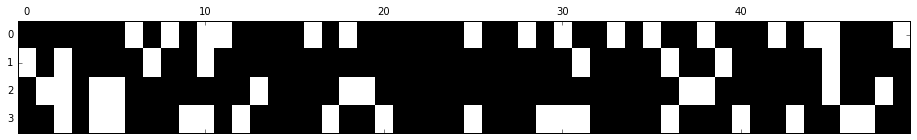

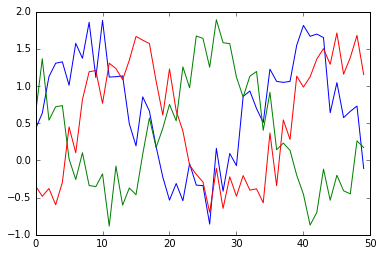

In [6]:
dX = np.sin(np.arange(NS)/5. + 2.5 * np.arange(P)[:, np.newaxis]) + np.random.rand(P, NS)

import scipy.stats as stats

# ddelta = stats.beta.rvs(1.2, 1, size=(K,))
# dpi = np.cumprod(ddelta)
dpi = np.array([0.3, 0.2, 0.2, 0.2])
# print(ddelta, dpi)
dZ = stats.bernoulli.rvs(dpi[:, np.newaxis], size=(K, NS))

# plot states
plt.matshow(dZ, aspect='auto', cmap='gray');

# plot X
plt.figure()
plt.plot(dX.T);

In [7]:
# check rank of Zmat
np.linalg.eig(dZ.dot(dZ.T)), dZ.mean(1)

((array([ 22.82576439,  13.6281681 ,   9.25920449,   6.28686303]),
  array([[ 0.55140148,  0.77479489,  0.30557872,  0.04765435],
         [ 0.30814679, -0.12943073, -0.08143368, -0.93896847],
         [ 0.36544092,  0.08647599, -0.90780132,  0.18673939],
         [ 0.68370674, -0.61274992,  0.27547589,  0.28494854]])),
 array([ 0.32,  0.16,  0.22,  0.34]))

# Generate trial set

In [8]:
dU, dS = np.meshgrid(range(NU), range(NS))
dU = dU.ravel()
dS = dS.ravel()

In [9]:
dlam_mean = np.tile(dA[dU] + np.sum(dB[dU] * dX[:, dS].T, axis=1) + np.sum(dC[dU] * dZ[:, dS].T, axis=1), Nrep)

dlam = stats.norm.rvs(loc=dlam_mean, scale=0.01)

In [10]:
dcount = stats.poisson.rvs(np.exp(dlam))
dcount.shape

(100000,)

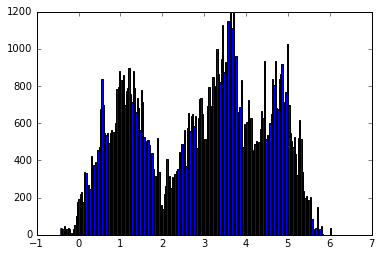

In [11]:
plt.hist(dlam, bins=200);

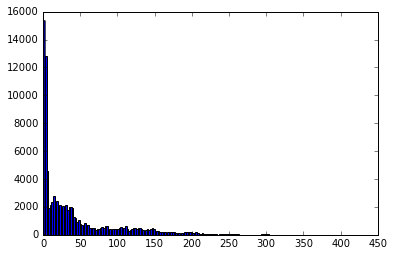

In [12]:
plt.hist(np.exp(dlam), bins=200);

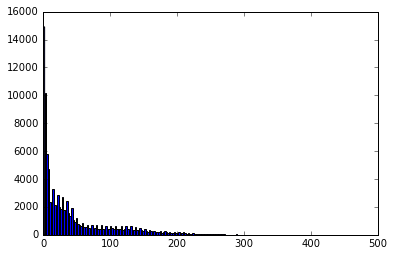

In [13]:
plt.hist(dcount, bins=200);

# Set up data

In [14]:
count = dcount.copy()
Xdat = np.tile(dX[:, dS], (1, Nrep)).T
unit = np.tile(dU, Nrep)
stim = np.tile(dS, Nrep)

Later, we'll need to know the number of observations of each (stim, unit) pair. This is constant for this toy example, but need not be.

In [15]:
pairs = pd.DataFrame({'stim': stim, 'unit': unit, 'count': 1})

In [16]:
# count the number of occurrences of each pair
pair_counts_df_long = pairs.groupby(['stim', 'unit']).sum().reset_index()
pair_counts_df_long.head()

,stim,unit,count
0,0,0,40
1,0,1,40
2,0,2,40
3,0,3,40
4,0,4,40


In [17]:
pair_counts_df = pair_counts_df_long.pivot(values='count', index='stim', columns='unit')
pair_counts_df.head()

unit,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
stim,,,,,,,,,,,,,,,,,,,,,
0,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
1,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
2,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
3,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
4,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40


In [18]:
pair_counts = pair_counts_df.values

We'd also like to know a unique code for each *possible* (stim, unit) pair. (Some might be missing, but in this case, we still want to code that, since we'll be using these codes to sum over all observations, and the resulting matrix may have some 0 entries, but it must be dense.

We will assume that units and stims are consecutively numbered.

In [19]:
# assuming an array stims x units, these are codes laid out in (C) memory order
# this is necessary so that after aggregating, we can reshape these codes to get
# an NS x NU array
su_codes = NU * stim + unit
su_codes

array([   0,    1,    2, ..., 2497, 2498, 2499])

# Define the model

## Constants

In [20]:
# define some needed constants
N = Xdat.shape[0]  # number of trials

In [21]:
N

100000

## Inputs and data

In [22]:
X = tf.constant(Xdat.astype('float32'))
U = tf.constant(unit)
S = tf.constant(stim)
counts = tf.constant(count)
allinds = tf.constant(np.arange(N))
NSU = tf.constant(pair_counts.astype('float32'))
codes_SU = tf.constant(su_codes)

In [23]:
X.get_shape()

TensorShape([Dimension(100000), Dimension(3)])

Make a node that produces `NB` indices from the range $[0, N - 1]$. These are the subset of data points we want to use.

In [24]:
NB = N
batch_inds = np.arange(N)
batch_counts = counts

## Generative (p) model

In [25]:
with tf.variable_scope("pmodel"):
    muA = ed.models.Normal(mu=np.log(25) * tf.ones(1), sigma=0.5 * tf.ones(1), name='mu_A')
    muB = ed.models.Normal(mu=tf.zeros(P), sigma=0.5 * tf.ones(P), name='mu_B')
    muC = ed.models.Normal(mu=tf.zeros(K), sigma=0.5 * tf.ones(K), name='mu_C')
    sigA = ed.models.Gamma(alpha=2. * tf.ones(1), beta=4. * tf.ones(1), name='sig_A')
    sigB = ed.models.Gamma(alpha=2. * tf.ones(P), beta=4. * tf.ones(P), name='sig_B')
    sigC = ed.models.Gamma(alpha=2. * tf.ones(K), beta=4. * tf.ones(K), name='sig_C') 

    A = ed.models.Normal(mu=tf.tile(muA, (NU,)), 
                         sigma=tf.tile(sigA, (NU,)), 
                         name='A')
    B = ed.models.Normal(mu=tf.tile(tf.expand_dims(muB, 0), (NU, 1)), 
                         sigma=tf.tile(tf.expand_dims(sigB, 0), (NU, 1)), 
                         name='B')
    C = ed.models.Normal(mu=tf.tile(tf.expand_dims(muC, 0), (NU, 1)), 
                         sigma=tf.tile(tf.expand_dims(sigC, 0), (NU, 1)), 
                         name='C')  

    a_prior = tf.ones(K)
    b_prior = tf.ones(K)
    pi = ed.models.Beta(a=a_prior, b=b_prior, name='pi')

    Z = ed.models.Bernoulli(p=tf.tile(tf.expand_dims(pi, 0), [NS, 1]), name='Z')

    sig = ed.models.Normal(mu=[-7.0], sigma=[1.], name='sig')

    lam_vars = (tf.gather(A, U) + tf.reduce_sum(tf.gather(B, U) * X, 1) + 
           tf.reduce_sum(tf.gather(C, U) * tf.gather(tf.to_float(Z), S), 1))
    lam = ed.models.Normal(mu=tf.gather(lam_vars, batch_inds), 
                           sigma=tf.exp(sig), name='lam')

    cnt = ed.models.Poisson(lam=tf.exp(lam), value=tf.ones(NB), name='cnt')

# Recognition (q) model

In [26]:
with tf.variable_scope("qmodel"):
    # population means
    q_muA = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(np.log(25) * tf.ones(1)), 
                                              sigma=tf.Variable(0.5 * tf.ones(1)),
                                              name='mu_A')
    tf.scalar_summary('q_muA', tf.reduce_mean(q_muA.mean()))

    q_muB = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.zeros(P)), 
                                              sigma=tf.Variable(0.5 * tf.ones(P)),
                                              name='mu_B')
    tf.scalar_summary('q_muB', tf.reduce_mean(q_muB.mean()))

    q_muC = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.zeros(K)), 
                                              sigma=tf.Variable(0.5 * tf.ones(K)),
                                              name='mu_C')
    tf.scalar_summary('q_muC', tf.reduce_mean(q_muC.mean()))


    # population standard deviations
    q_sigA = ed.models.GammaWithSoftplusAlphaBeta(alpha=tf.Variable(2. * tf.ones(1)), 
                                                  beta=tf.Variable(4. * tf.ones(1)),
                                                  name='sig_A')
    tf.scalar_summary('q_sigA', tf.reduce_mean(q_sigA.mean()))

    q_sigB = ed.models.GammaWithSoftplusAlphaBeta(alpha=tf.Variable(2. * tf.ones(P)), 
                                                  beta=tf.Variable(4. * tf.ones(P)),
                                                  name='sig_B')
    tf.scalar_summary('q_sigB', tf.reduce_mean(q_sigB.mean()))

    q_sigC = ed.models.GammaWithSoftplusAlphaBeta(alpha=tf.Variable(2. * tf.ones(K)), 
                                                  beta=tf.Variable(4. * tf.ones(K)),
                                                  name='sig_C')
    tf.scalar_summary('q_sigC', tf.reduce_mean(q_sigC.mean()))

    
    # individual unit coefficients
    q_A = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(np.log(25) + tf.random_normal((NU,))), 
                                            sigma=tf.Variable(0.5 + tf.random_uniform((NU,))),
                                            name='A')
    tf.scalar_summary('q_A', tf.reduce_mean(q_A.mean()))

    q_B = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, P))), 
                                            sigma=tf.Variable(0.5 + tf.random_uniform((NU, P))),
                                            name='B')
    tf.scalar_summary('q_B', tf.reduce_mean(q_B.mean()))

    q_C = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, K))), 
                                            sigma=tf.Variable(0.5 + tf.random_uniform((NU, K))),
                                            name='C')
    tf.scalar_summary('q_C', tf.reduce_mean(q_C.mean()))
    
    # latent variables for each stimulus
    Zlogit = tf.Variable(-0.0 + tf.zeros((NS, K)), name='Z_logit')
    tf.scalar_summary('max_Z_logit', tf.reduce_max(Zlogit))
    tf.scalar_summary('min_Z_logit', tf.reduce_min(Zlogit))
    q_Z = ed.models.BernoulliWithSigmoidP(p=Zlogit, name='Z')
    tf.scalar_summary('q_Z', tf.reduce_mean(q_Z.mean()))
    tf.scalar_summary('max_q_Z', tf.reduce_max(q_Z.mean()))
    tf.scalar_summary('min_q_Z', tf.reduce_min(q_Z.mean()))

    # latent variables for stimulus category
    a_var = tf.Variable(1. + tf.random_uniform((K,)))
    b_var = tf.Variable(1. + tf.random_uniform((K,)))
    tf.scalar_summary('max_a', tf.reduce_max(a_var))
    tf.scalar_summary('max_b', tf.reduce_max(b_var))
    tf.scalar_summary('min_a', tf.reduce_min(a_var))
    tf.scalar_summary('min_b', tf.reduce_min(b_var))
    q_pi = ed.models.Beta(a=a_var, b=b_var, name='pi')
    tf.scalar_summary('min_q_pi', tf.reduce_min(q_pi.value()))
    tf.scalar_summary('max_q_pi', tf.reduce_max(q_pi.value()))

    # log firing rates
    lam_mu = tf.Variable(2 + tf.random_normal((N,)))
    tf.scalar_summary('lam_mu_mean', tf.reduce_mean(tf.gather(lam_mu, batch_inds)))
    lam_sig = tf.Variable(3 * tf.random_uniform((N,)) + 2)
    q_lam = ed.models.NormalWithSoftplusSigma(mu=tf.gather(lam_mu, batch_inds),
                                              sigma=tf.gather(lam_sig, batch_inds),
                                              name='lam')

    q_sig = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(-0.1 * tf.random_uniform((1,))),
                                              sigma=tf.Variable(tf.random_uniform((1,))),
                                              name='sig')

# ELBO

In [27]:
def make_ELBO(latent_vars, data, scale):
    from edward.util import copy
    p_log_prob = 0.0
    q_log_prob = 0.0
    z_sample = {}
    scope = "ELBO"

    for z, qz in latent_vars.items():
        # Copy q(z) to obtain new set of posterior samples.
        qz_copy = copy(qz, scope=scope)
        z_sample[z] = qz_copy.value()
        z_log_prob = tf.reduce_sum(qz.log_prob(tf.stop_gradient(z_sample[z])))
        if z in scale:
            z_log_prob *= scale[z]

        q_log_prob += z_log_prob

    dict_swap = z_sample
    for x, qx in data.items():
        if isinstance(x, ed.RandomVariable):
            if isinstance(qx, ed.RandomVariable):
                qx_copy = copy(qx, scope=scope)
                dict_swap[x] = qx_copy.value()
            else:
                dict_swap[x] = qx

            for z in latent_vars.keys():
                z_copy = copy(z, dict_swap, scope=scope)
                z_log_prob = tf.reduce_sum(z_copy.log_prob(dict_swap[z]))
                if z in scale:
                    z_log_prob *= scale[z]

                p_log_prob += z_log_prob

            for x in data.keys():
                if isinstance(x, ed.RandomVariable):
                    x_copy = copy(x, dict_swap, scope=scope)
                    x_log_prob = tf.reduce_sum(x_copy.log_prob(dict_swap[x]))
                if x in scale:
                    x_log_prob *= scale[x]

                p_log_prob += x_log_prob

    return tf.reduce_mean(p_log_prob - q_log_prob)

In [28]:
elbo = make_ELBO({A: q_A, B: q_B, C: q_C, 
                  muA: q_muA, muB: q_muB, muC: q_muC,
                  sigA: q_sigA, sigB: q_sigB, sigC: q_sigC,
                  Z: q_Z, sig: q_sig, pi: q_pi, lam: q_lam}, 
                 {cnt: tf.cast(batch_counts, 'float32')}, 
                 {lam: N/NB, cnt: N/NB})

tf.scalar_summary('ELBO', elbo)

<tf.Tensor 'ScalarSummary:0' shape=() dtype=string>

# Do variational inference

Given $z_{sk} \sim \mathrm{Ber}(\pi_k)$ and $\log \Lambda \equiv \lambda_{su} \sim \mathcal{N}(A_u + (B \cdot X)_{su} + (C \cdot Z)_{su}, \sigma^2)$, we can calculate closed-form updates for $Z$. However, above, we have flattened $\lambda$ into a single vector for each trial, with vectors $S$ and $U$ listing the stimulus and unit corresponding to each observation.

Collecting the pieces involving $\xi_{sk} = \mathbb{E}[Z_{sk}]$ in the ELBO (prior to expectations wrt $q(A, B, C, \lambda)$), we have:

$$
\begin{align}
\mathcal{L} &=
\sum_{sk}\xi_{sk}\log \frac{\pi_k}{1 - \pi_k} + \mathcal{M} + \sum_{sk} \mathcal{H}(\xi_{sk})\\
\mathcal{H}(\xi_{sk}) &= -\xi_{sk}\log \xi_{sk} - (1 - \xi_{sk})\log (1 - \xi_{sk}) \\
\mathcal{M} &= -\frac{1}{2\sigma^2}\sum_{s,u,j=1\ldots N_{us}} \mathbb{E}_z 
\left[
-2(C \cdot Z)_{su}(\lambda^{(j)}_{su} - A_u - (B\cdot X)_{su}) + (C \cdot Z)_{su}^2
\right] \\
&= -\frac{1}{2\sigma^2}\sum_{suj} \left[
-2(C \cdot \xi)_{su} (\lambda^{(j)}_{su} - A_u - (B\cdot X)_{su}) 
+ \sum_{k\neq k'} C_{uk}C_{uk'} \xi_{sk}\xi_{sk'} + \sum_k C^2_{uk}\xi_{sk}
\right] \\
&= -\frac{1}{2\sigma^2}\sum_{suj} \left[
-2(C \cdot \xi)_{su} (\lambda^{(j)}_{su} - A_u - (B\cdot X)_{su}) 
+ (C \cdot \xi)^2_{su} + \sum_k C^2_{uk}\xi_{sk}(1 - \xi_{sk})
\right]
\end{align}
$$

where the derivation expands the square in the log of the normal distribution and makes use of the fact that $z_{ks} \in \{ 0, 1\} \Rightarrow z_{ks}^2 = z_{ks}$. In addition, we have let $N_{su}$ be the number of observations of stimulus $s$ by unit $u$, indexed by $j$.

Given this result, differentiating wrt $\xi$ and solving for the fixed point gives the result

$$
\begin{align}
\log \frac{\xi_{sk}}{1 - \xi_{sk}} &= 
\log \frac{\pi_k}{1 - \pi_k}
-\frac{1}{2\sigma^2} \sum_{uj} \left[
-2C_{uk} (\lambda^{(j)}_{su} - A_u - (B\cdot X)_{su} - (C \cdot \xi)_{su}) 
+ C^2_{uk}(1 - 2\xi_{sk})
\right]
\end{align}
$$

Note that despite appearances, the right hand side does *not* depend on $\xi_{sk}$. This means that we can 
solve for $\xi_{sk}$ given $\xi_{sk'}$ for $k' \neq k$. Solving for all these equations simultaneously is not possible in general in closed form, but it leaves two options:
1. Solve for all $\xi^{(t)}_{sk}$ given $\xi^{(t - 1)}_{sk}$, the values at the previous iteration.
1. Iterate through $k$, updating each $\xi_{sk}$ in turn given the current value of the others. In this method, the first $k$ chosen uses the values from the previous iteration, while the last $k$ uses updated values. 

In addition, if we make the assumption that the posterior over $C$ is normally distributed, we can take the expectation of the above update rule wrt $C$. (The expectations wrt $A$, $B$, and $\lambda$ are trivial. Since each only appears linearly, we only need to know the mean of the approximate posterior. For $\sigma$, we would need a posterior that allows us to compute $\mathbb{E}[\sigma^{-2}]$.)

In this case, it is straightforward to work out that
$$
\begin{align}
\log \frac{\xi_{sk}}{1 - \xi_{sk}} &= 
\log \frac{\pi_k}{1 - \pi_k}
-\frac{1}{2\sigma^2} \sum_{uj} \left[
-2\overline{C}_{uk} (\lambda^{(j)}_{su} - A_u - (B\cdot X)_{su} - (\overline{C} \cdot \xi)_{su}) 
+ \overline{C}^2_{uk}(1 - 2\xi_{sk}) + \mathrm{var}[C]_{uk}
\right]
\end{align}
$$
using 
$$
\mathbb{E}_z \left[
2 C_{uk}(C \cdot \xi)_{su} + C^2_{uk}(1 - 2\xi_{sk})
\right]
=
2 \overline{C}_{uk}(\overline{C}\cdot \xi)_{su} + \overline{C}^2_{uk}(1 - 2\xi_{sk}) + \mathrm{var}[C]_{uk}
$$

In [29]:
def update_z():
    # update binary features based on exact conjugate update
    with tf.variable_scope("update_z"):
        # logit piece
        pi_val = q_pi.value()
        logit_pi = tf.log(pi_val) - tf.log(1. - pi_val)
        
        # E[Z]
        xi = q_Z.mean()  # (NS x K)

        # C^2 * (1 - 2xi) piece
        C = q_C.value()  # NU x K
        # \sum_u N_{su} C^2_{uk} has indices (sk)
        sum_uj_C2 = tf.matmul(NSU, tf.square(C))  # NS x K 
        quad_piece = sum_uj_C2 * (1 - 2 * xi)

        # sample log firing rate values
        lam_val = q_lam.value()

        # now get \lam_{su} summed over observations
        lam_su_flat = tf.unsorted_segment_sum(lam_val, codes_SU, NS * NU, name='lam_collect')
        lam_su = tf.reshape(lam_su_flat, (NS, NU), name='lam_su')

        # get A, BX, and CZ (summed over observations)
        # recall that X is in "long" format, and so must 
        # be handled with unsorted_segment_sum, like lambda
        A = NSU * tf.expand_dims(q_A.value(), 0)  # now NS x NU
        BX_long = tf.reduce_sum(tf.gather(B, U) * X, 1)
        BX_summed = tf.unsorted_segment_sum(BX_long, codes_SU, NS * NU)  # now NS x NU
        BX = tf.reshape(BX_summed, (NS, NU))
        CZ = NSU * tf.matmul(xi, C, transpose_b=True)  # now NS x NU (\sum_k xi_{sk} C_{uk})

        # lam_{su} * C_{uk}
        lin_piece = tf.matmul(lam_su - A - BX - CZ, C, name='linear_piece')

        prec = 1/tf.square(q_sig.value())

        z_coeff = logit_pi - prec * (0.5 * quad_piece - lin_piece)
        
        update_z_op = [Zlogit[:, k].assign(z_coeff[:, k]) for k in range(K)]
                
        return update_z_op

In [30]:
def update_pi():
    # update probabilites for features based on exact conjugate update
    with tf.variable_scope("update_pi"):
        xi = q_Z.mean()
        new_a = tf.reduce_sum(xi, 0) + a_prior
        new_b = tf.reduce_sum(1. - xi, 0) + b_prior
        update_a_op = a_var.assign(new_a)
        update_b_op = b_var.assign(new_b)
        
    return [update_a_op, update_b_op]

In [31]:
data = {cnt: batch_counts}
inference_lam = ed.KLqp({lam: q_lam, sig: q_sig}, 
                        data={cnt: batch_counts, 
                              Z: q_Z, pi: q_pi, 
                              A: q_A, B: q_B, C: q_C,
                              muA: q_muA, muB: q_muB, muC: q_muC,
                              sigA: q_sigA, sigB: q_sigB, sigC: q_sigC})
inference_coeffs = ed.KLqp({A: q_A, B: q_B, C: q_C}, 
                           data={cnt: batch_counts, 
                                 lam: q_lam, sig: q_sig,
                                 Z: q_Z, pi: q_pi, 
                                 muA: q_muA, muB: q_muB, muC: q_muC,
                                 sigA: q_sigA, sigB: q_sigB, sigC: q_sigC})
inference_pop = ed.KLqp({muA: q_muA, muB: q_muB, muC: q_muC,
                        sigA: q_sigA, sigB: q_sigB, sigC: q_sigC},
                       data={cnt: batch_counts, 
                             lam: q_lam, sig: q_sig,
                             Z: q_Z, pi: q_pi, 
                             A: q_A, B: q_B, C: q_C})
inference_latents = update_z()
inference_probs = update_pi()

# Notes on inference:

- The `logdir` keyword specifies the place to put the log file (assuming you've instrumented the code to save events, etc.). If a subdirectory is given, pointing Tensorboard at the parent directory allows you to compare across subdirectories (runs).
    - ~~I'm using the `jmp/instrumented` branch of the `jmxpearson/edward` fork~~ No longer needed after Edward PR merged.
- The learning rate is a difficult tradeoff: 1e-2 drastically speeds convergence but can run into NaNs; 1e-3 (the default) is much slower.
    - **TO DO**: Does regularizing emergence of `NaN`s help with this?
    - **Update**: I had to hack TF's implementation of `Beta` to include fudge factors in `logp` and a couple of other places in order to remove NaNs.
- I'm currently using "all" the data, which appears to be faster (run-time, wise) than using minibatches. (Not entirely sure why this is, except perhaps that switching data into and out of the graph has a cost.) I've also found that minibatches need to be fairly substantial to be effective, since most variables ($\lambda$, $A$, $B$, $C$) are unit-specific (i.e., local), so unless you have several observations from that unit, convergence can be slow.
    - Ultimately, it might speed things to have a smarter minibatch selection (i.e., all observations for a single unit) when updating the local variables.
- I've used `n_samples` = 1, 5, 10, and 25, which all seem pretty similar after 10k iterations.
    - Follow-up: since adding explicit (non-gradient) optimization steps, this may be moot, since those update operations aren't code to handle multiple samples. Would need `tf.reduce*` sprinkled here and there to work.
- I've noticed no difference below in how many steps one takes along each coordinate before switching (number of inner loop iterations), either in runtime or convergence. Perhaps this matters in the final stages, but I would suspect that then it favors tighter inner loops.
- As per Edward documentation and my own experience: it really helps to have separate updates for "local" and "global" variables. This is why $\lambda$ and $(A, B, C)$ are updated separately. Same idea with the hierarchy.
- Updating the discrete pieces ($Z$ and $\pi$) was terrible. This is most likely because the minima for $Z$ are all near 0 and 1, and it's very hard to get there without making large moves.

In [32]:
# Initialize each (Edward) inference step
debug = False
inf_list = [inference_lam, inference_coeffs, inference_pop]
# inf_list = [inference_lam, inference_coeffs]

for inf in inf_list:
    if inf is inference_lam:
        logdir = 'data/run7'
    else:
        logdir = None
        
    inf.initialize(n_print=100, n_samples=1,  
                  logdir=logdir,
                  optimizer=tf.train.AdamOptimizer(1e-4),
                  scale={lam: N/NB, cnt: N/NB},
                  debug=debug)

In [110]:
init = tf.initialize_all_variables()
init.run({})

In [111]:
n_iter = 480000
sess = tf.get_default_session()
for _ in range(n_iter):
    for inf in inf_list:
        for _ in range(1):  # make multiple steps along each set of coords
            info_dict = inf.update()
        if inf is inference_lam:
            inf.print_progress(info_dict)
    sess.run(inference_latents)
    sess.run(inference_probs)

Iteration    1 [  0%]: Loss = 4954811904.000
Iteration  100 [ 10%]: Loss = 17835325440.000
Iteration  200 [ 20%]: Loss = 5662798848.000
Iteration  300 [ 30%]: Loss = 3283558656.000
Iteration  400 [ 40%]: Loss = 5969296384.000
Iteration  500 [ 50%]: Loss = 3695660800.000
Iteration  600 [ 60%]: Loss = 3717876224.000
Iteration  700 [ 70%]: Loss = 37279600640.000
Iteration  800 [ 80%]: Loss = 27883968512.000
Iteration  900 [ 90%]: Loss = 5466150400.000
Iteration 1000 [100%]: Loss = 38729895936.000
Iteration 1100 [110%]: Loss = 6549427712.000
Iteration 1200 [120%]: Loss = 2388050688.000
Iteration 1300 [130%]: Loss = 9758369792.000
Iteration 1400 [140%]: Loss = 19333754880.000
Iteration 1500 [150%]: Loss = 6208064000.000
Iteration 1600 [160%]: Loss = 3176133632.000
Iteration 1700 [170%]: Loss = 7919713280.000
Iteration 1800 [180%]: Loss = 6691961344.000
Iteration 1900 [190%]: Loss = 6963802624.000
Iteration 2000 [200%]: Loss = 3579017984.000
Iteration 2100 [210%]: Loss = 7161090560.000
Itera

KeyboardInterrupt: 

In [ ]:
Zmat = q_Z.mean().eval()

plt.matshow(dZ, aspect='auto', cmap='gray')
plt.matshow(Zmat.T, aspect='auto', cmap='gray')

In [ ]:
plt.hist(q_A.mean().eval().ravel(), label='inferred'); plt.hist(dA.ravel(), label='actual'), plt.legend();

In [ ]:
plt.scatter(dA.ravel(), q_A.mean().eval().ravel())
plt.xlabel('actual')
plt.ylabel('inferred')

In [ ]:
plt.hist(q_B.mean().eval().ravel(), 200, label='inferred'), plt.hist(dB.ravel(), 200, label='actual'), plt.legend();

In [ ]:
plt.scatter(dB.ravel(), q_B.mean().eval().ravel())
plt.xlabel('actual')
plt.ylabel('inferred')

In [ ]:
plt.hist(q_C.mean().eval().ravel(), 200, label='inferred'), plt.hist(dC.ravel(), 200, label='actual'), plt.legend();

In [ ]:
dC.mean(0), q_C.mean().eval().mean(0)

In [ ]:
plt.scatter(dC.ravel(), q_C.mean().eval().ravel())
plt.xlabel('actual')
plt.ylabel('inferred')

## More evaluation
Let's try to solve $C\cdot R = C'$, where $C' = \mathbb{E}[q_C]$.

In [ ]:
rot = np.linalg.solve(dC.T.dot(dC), dC.T.dot(q_C.mean().eval()))
rotinv = np.linalg.inv(rot)
plt.scatter(dC.dot(rot).ravel(), q_C.mean().eval().ravel())
plt.xlabel('actual')
plt.ylabel('inferred')
print(rot)

For invariance of $C \cdot Z^\top$ under $C \rightarrow C\cdot R$, we need $Z \rightarrow Z \cdot R^{-\top}$ or
$Z^\top \rightarrow R^{-1} \cdot Z^\top$.

In [ ]:
Zmat = q_Z.mean().eval()

# plt.matshow(dZ, aspect='auto', cmap='gray')
plt.matshow(rotinv.dot(Zmat.T), aspect='auto', cmap='gray')

In [ ]:
CZ_actual = dC.dot(dZ)
CZ_mean = q_C.mean().eval().dot(Zmat.T)
plt.matshow(CZ_actual, cmap='gray')
plt.matshow(CZ_mean, cmap='gray')
plt.matshow(np.abs(CZ_actual - CZ_mean), cmap='gray')
plt.colorbar()

## /Evaluation

In [ ]:
plt.hist(lam_mu.eval(), 200, label='inferred'), plt.hist(dlam, 200, label='actual'), plt.legend();

In [ ]:
plt.scatter(dlam.ravel(), lam_mu.eval().ravel())
plt.xlabel('actual')
plt.ylabel('inferred')

In [ ]:
lam_mu.value().eval()

In [ ]:
q_lam.mean().eval()

In [ ]:
q_sig.mean().eval()

In [ ]:
q_pi._value.eval()

In [ ]:
q_pi.std().eval()

In [ ]:
q_pi.mean().eval()